<h1 style='color:white; background:black; border:0'><center>How is Data Science on Reddit?</center></h1>

![](https://storage.googleapis.com/kaggle-datasets-images/1226967/2048152/b7b21a6c2113257ec9ddf7221abfed1a/dataset-cover.png?t=2021-03-23-12-43-24)

**Data Science Community on Reddit is growing every year. Today, the network is a platform for many professionals and enthusiasts who share valuable materials and experiences. Quite an interesting task is the analysis of posts dedicated to Data Science:**
- **finding interesting topics**, 
- **studying changes in trends over time**, 
- **predicting the potential popularity of posts on Reddit by its title and text**, etc.

**Over time, I will increase the size of this dataset by adding posts from other subreddits, so that the quality of the analysis will improve.**

<h3 style='color:white; background:black; border:0'><center>This dataset includes over 500,000 posts from 19 Date Science subreddits:</center></h3>

[r/analytics](https://www.reddit.com/r/analytics/), [r/deeplearning](https://www.reddit.com/r/deeplearning/), [r/datascience](https://www.reddit.com/r/datascience/), [r/datasets](https://www.reddit.com/r/datasets/), [r/kaggle](https://www.reddit.com/r/kaggle/), [r/learnmachinelearning](https://www.reddit.com/r/learnmachinelearning/), [r/MachineLearning](https://www.reddit.com/r/MachineLearning/), [r/statistics](https://www.reddit.com/r/statistics/), [r/artificial](https://www.reddit.com/r/artificial/), [r/AskStatistics](https://www.reddit.com/r/AskStatistics/), [r/computerscience](https://www.reddit.com/r/computerscience/), [r/computervision](https://www.reddit.com/r/computervision/), [r/dataanalysis](https://www.reddit.com/r/dataanalysis/), [r/dataengineering](https://www.reddit.com/r/dataengineering/), [r/DataScienceJobs](https://www.reddit.com/r/DataScienceJobs/), [r/datascienceproject](https://www.reddit.com/r/datascienceproject/), [r/data](https://www.reddit.com/r/data/), [r/MLQuestions](https://www.reddit.com/r/MLQuestions/), [r/rstats](https://www.reddit.com/r/rstats/)

Data were collected from [pushshift.io API](https://pushshift.io) (maintained by Jason Baumgartner).

<h3 style='color:white; background:black; border:0'><center>19 datasets (one per one subreddit) include the following data:</center></h3>

`#` - row index;
`created_date` - post publication date;
`created_timestamp` - post publication timestamp;
`subreddit` - subreddit name;
`title` - post title;
`id` - unique operation id;
`author` - post author;
`author_created_utc` - author registration date;
`full_link` - hyperlink to post;
`score` - ratio of likes and dislikes;
`num_comments` - the number of comments;
`num_crossposts` - the number of crossposts; 
`subreddit_subscribers` - the number of subreddit subscribers at the time the post was published;
`post` - post text.

# If you are interested, see [this dataset (Reddit Data Science Posts)](https://www.kaggle.com/maksymshkliarevskyi/reddit-data-science-posts).
Feel free to leave your comments on this notebook. I will try to make dataset better and much larger.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import tqdm
from tqdm.auto import tqdm as tqdmp
tqdmp.pandas()

# NLP
import unicodedata, string, re, os
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

# Some settings for visualizations
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 
            'xtick.color': 'white', 'ytick.color': 'white', 
            'grid.color': 'white', 'axes.labelcolor': 'white',
            'figure.dpi': 150, 'grid.linestyle': ':', 'grid.alpha': .6,
            'font.family': 'fantasy'})

# RAPIDS
import tensorflow as tf
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS',cuml.__version__)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


RAPIDS 0.16.0


### Load data

In [2]:
all_data = pd.read_csv('../input/reddit-data-science-posts/reddit_database.csv')
all_data['created_date'] = all_data['created_date'].astype('datetime64')
all_data.head()

created_date  created_timestamp  subreddit  \
0 2010-02-10 22:06:17       1.265832e+09  analytics   
1 2010-02-10 22:06:53       1.265832e+09  analytics   
2 2010-02-11 19:47:22       1.265910e+09  analytics   
3 2010-02-12 18:10:36       1.265991e+09  analytics   
4 2010-02-26 20:26:18       1.267209e+09  analytics   

                                               title     id     author  \
0        YouTube's traffic data for music questioned  b0ih7    salvage   
1  November Sees Number of U.S. Videos Viewed Onl...  b0ihf    salvage   
2  So what do you guys all do related to analytic...  b0x63       xtom   
3  10 Web Analytics Tools For Tracking Your Visitors  b1bbg  [deleted]   
4                       Improving Your Sense of Site  b6x0n  [deleted]   

   author_created_utc                                          full_link  \
0        1.184143e+09  https://www.reddit.com/r/analytics/comments/b0...   
1        1.184143e+09  https://www.reddit.com/r/analytics/comments/b0...   
2        1.227476e+09  https://www.reddit.com/r/analytics/comments/b0...   
3                 NaN  https://www.reddit.com/r/analytics/comments/b1...   
4                 NaN  https://www.reddit.com/r/analytics/comments/b6...   

   score  num_comments  num_crossposts  subreddit_subscribers  \
0    3.0           0.0             0.0                    NaN   
1    1.0           0.0             0.0                    NaN   
2    7.0           4.0             0.0                    NaN   
3    4.0           1.0             0.0                    NaN   
4    2.0           0.0             0.0                    NaN   

                                                post  
0                                                NaN  
1                                                NaN  
2  There's a lot of reasons to want to know all t...  
3                                                NaN  
4                                                NaN

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527646 entries, 0 to 527645
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   created_date           527646 non-null  datetime64[ns]
 1   created_timestamp      527646 non-null  float64       
 2   subreddit              527646 non-null  object        
 3   title                  527646 non-null  object        
 4   id                     527646 non-null  object        
 5   author                 527646 non-null  object        
 6   author_created_utc     103319 non-null  float64       
 7   full_link              527646 non-null  object        
 8   score                  527646 non-null  float64       
 9   num_comments           527646 non-null  float64       
 10  num_crossposts         400013 non-null  float64       
 11  subreddit_subscribers  364379 non-null  float64       
 12  post                   262567 non-null  obje

In total, we have 527 646 posts. Of these, 262 567 have text body. The half is empty because it was either originally without text, or has been removed from the platform.

In [4]:
all_data.describe().style.background_gradient(cmap = 'inferno')

# Let's take a look at some interesting data

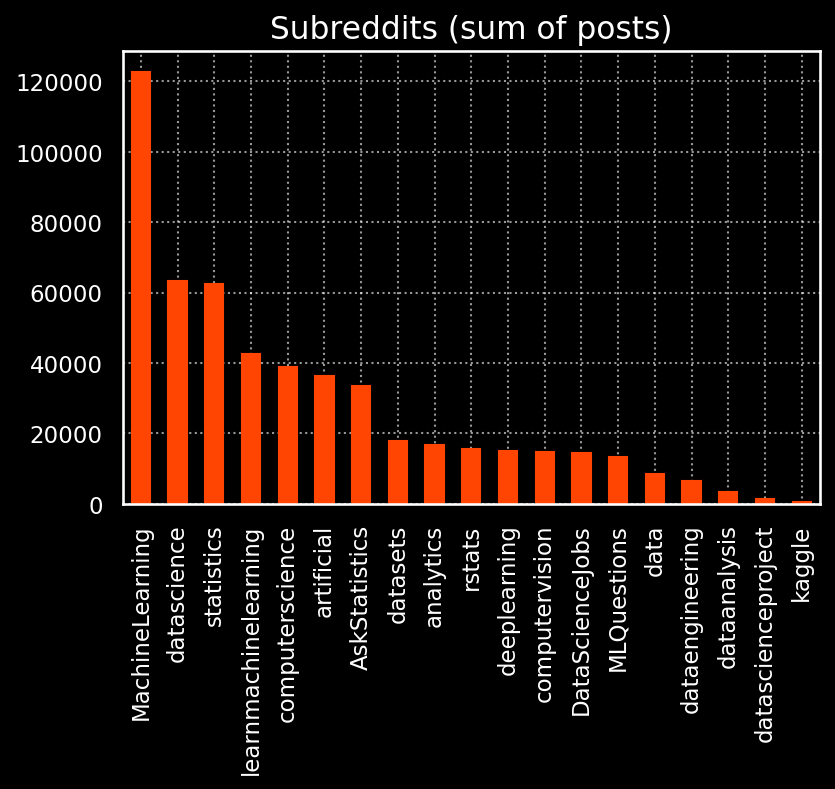

In [5]:
plt.title('Subreddits (sum of posts)', color = 'white', size = 15)
sub_redd = all_data.groupby(all_data["subreddit"]).created_date.count().sort_values(ascending = False)
sub_redd.plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xlabel('')
plt.show()

The r/MachineLearning subreddit has the largest number of posts. The smallest is r/kaggle (it is necessary to promote the kaggle community on Reddit!).

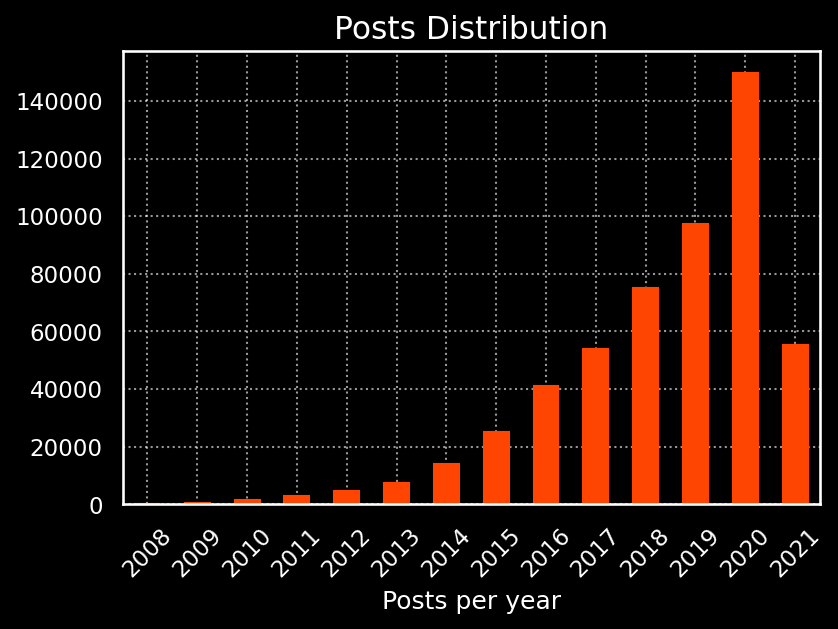

In [6]:
plt.title('Posts Distribution', color = 'white', size = 15)
year_d = all_data.groupby(all_data["created_date"].dt.year).created_date.count()
year_d.plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xlabel('Posts per year')
plt.xticks(rotation = 45)
plt.show()

Visual confirmation that the Data Science community on Reddit is growing.

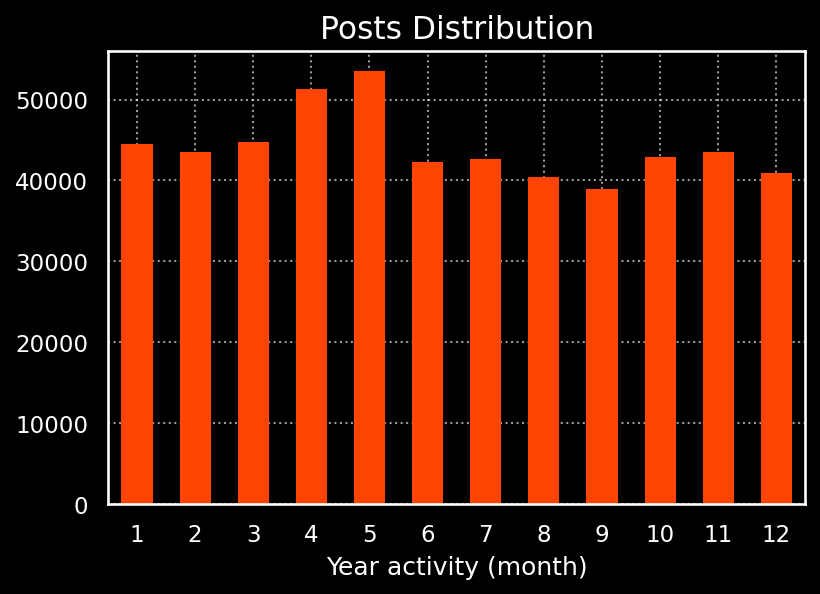

In [7]:
plt.title('Posts Distribution', color = 'white', size = 15)
month_d = all_data.groupby(all_data["created_date"].dt.month).created_date.count()
month_d.plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xlabel('Year activity (month)')
plt.xticks(rotation = 'horizontal')
plt.show()

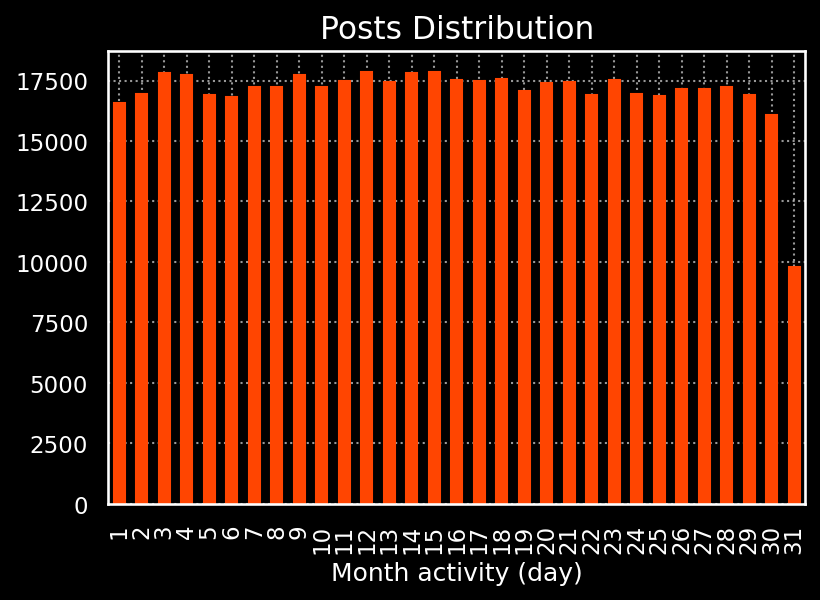

In [8]:
plt.title('Posts Distribution', color = 'white', size = 15)
day_d = all_data.groupby(all_data["created_date"].dt.day).created_date.count()
day_d.plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xlabel('Month activity (day)')
plt.show()

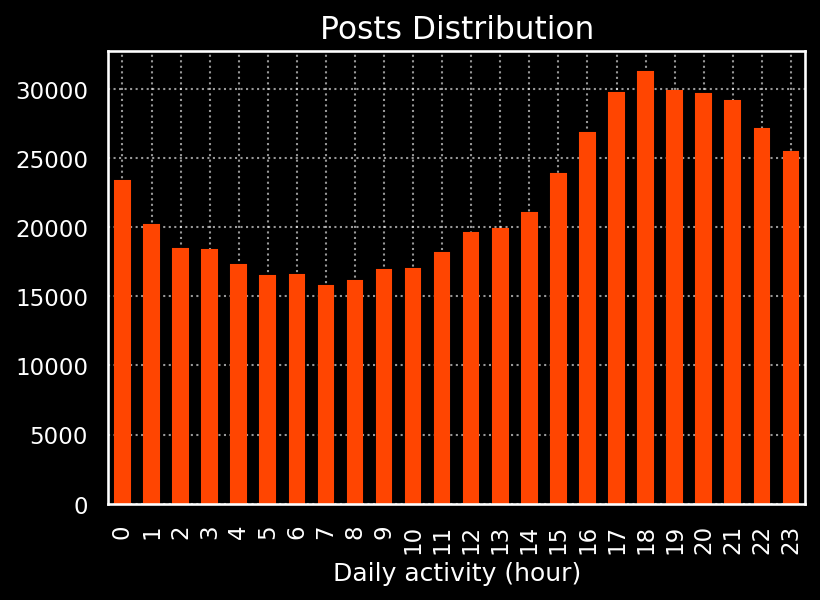

In [9]:
plt.title('Posts Distribution', color = 'white', size = 15)
hour_d = all_data.groupby(all_data["created_date"].dt.hour).created_date.count()
hour_d.plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xlabel('Daily activity (hour)')
plt.show()

There are no patterns in activity between months, and days of the month. Activity within a day is logically higher in the evening and at night.

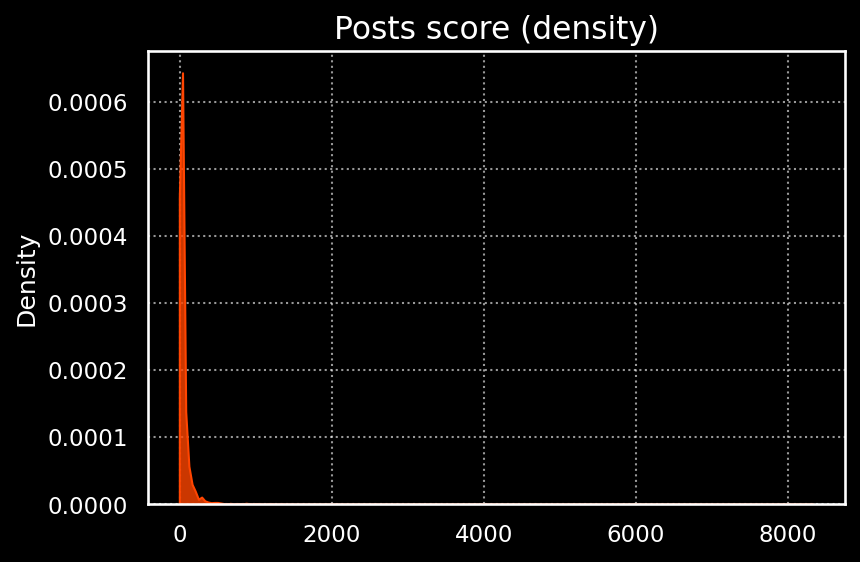

In [10]:
plt.title('Posts score (density)', color = 'white', size = 15)
sns.kdeplot(all_data['score'], color = '#ff4501', shade = True, 
            alpha = .8, legend = None)
plt.xlabel('')
plt.show()

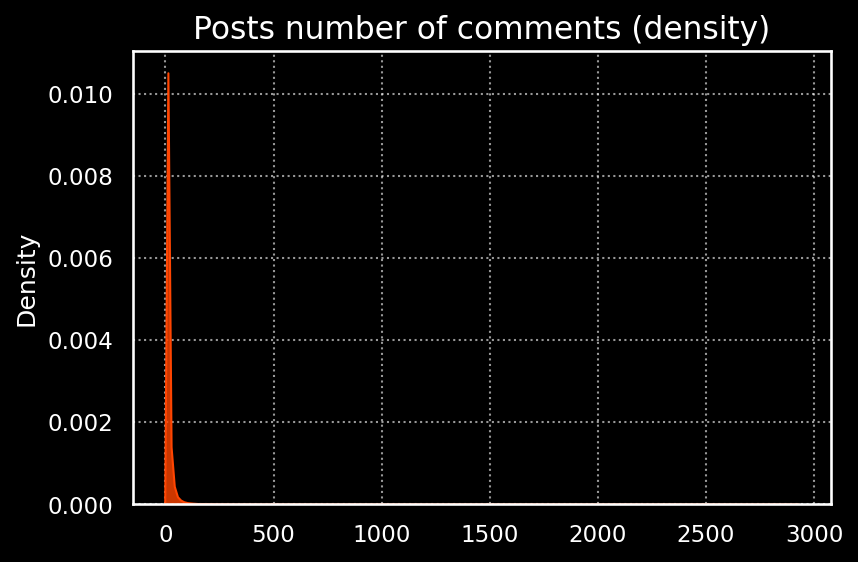

In [11]:
plt.title('Posts number of comments (density)', color = 'white', size = 15)
sns.kdeplot(all_data['num_comments'], color = '#ff4501', shade = True, 
            alpha = .8, legend = None)
plt.xlabel('')
plt.show()

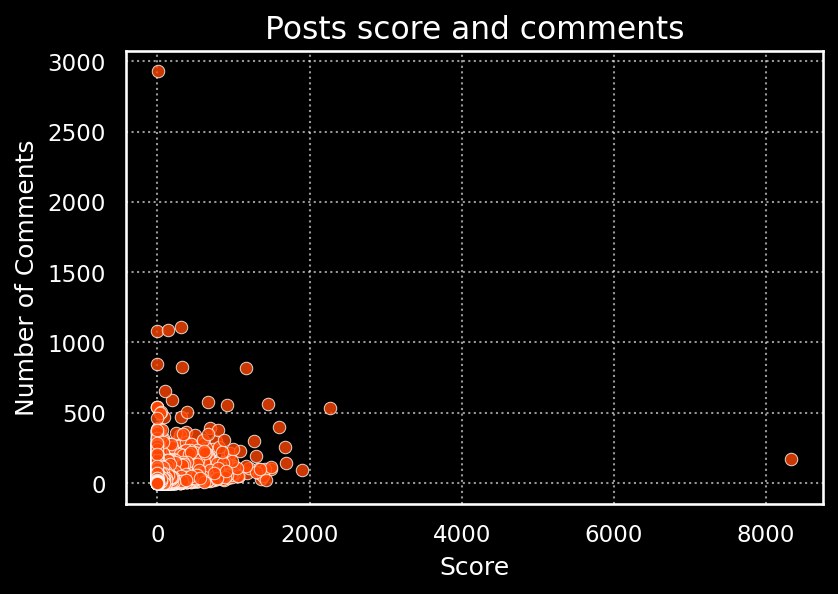

In [12]:
plt.title('Posts score and comments', color = 'white', size = 15)
sns.scatterplot(all_data['score'], all_data['num_comments'], 
                color = '#ff4501', alpha = .8, legend = None)
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.show()

The ratio between post rating and the number of comments is not so linear. There are posts with a huge number of likes, but almost no comments, and vice versa.

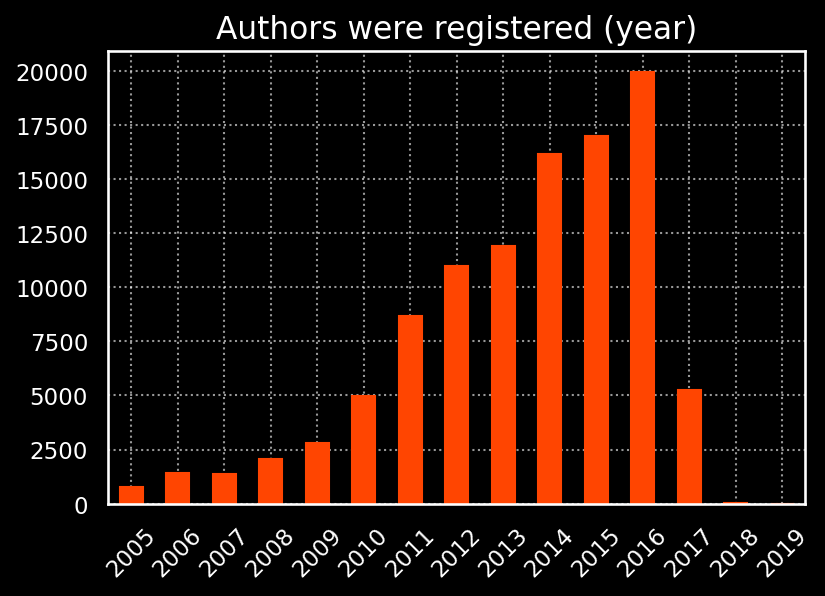

In [13]:
plt.title('Authors were registered (year)', color = 'white', size = 15)
all_data['author_created_utc'].dropna() \
    .apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')) \
    .astype('datetime64').dt.year.value_counts(sort = False) \
    .plot(kind = "bar", edgecolor = '#ff4501', color = '#ff4501')
plt.xticks(rotation = 45)
plt.show()

In the dynamics of authors' registration date, there is a regular increase. True, something has happened in recent years. This is most likely due to the data provided by "pushshift.io".

**Let's take a closer look at text data.**

In [14]:
# Necessary functions
def text_cleaner(text):
    """
    Function for clearing text data from unnecessary characters.
    """
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def show_wordcloud(data, stop, mask = None, title = None, color = 'black'):
    """
    Function for creating wordclouds (with or without mask)
    """
    from wordcloud import WordCloud, ImageColorGenerator
    wordcloud = WordCloud(background_color = color,
                         stopwords = stop,
                         mask = mask,
                         max_words = 100,
                         scale = 3,
                         width = 4000, 
                         height = 2000,
                         collocations = False,
                         random_state = 1)
    
    wordcloud = wordcloud.generate(data)
    
    plt.figure(1, figsize = (16, 8), dpi = 300)
    plt.title(title, size = 15)
    plt.axis('off')
    if mask is None:
        plt.imshow(wordcloud, interpolation = "bilinear")
        plt.show()
    else:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func = image_colors), 
                   interpolation = "bilinear")
        plt.show()
        
def get_top_ngram(corpus, n = 2):
    """
    Function for creating ngrams of words
    Input: word corpus and n - number of words in grams
    """
    vec = CountVectorizer(stop_words = stop, ngram_range = (n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq

In [15]:
title_cleaned = all_data['title'].progress_apply(lambda x: text_cleaner(x))
title_cleaned

  0%|          | 0/527646 [00:00<?, ?it/s]

0                youtubes traffic data for music questioned
1         november sees number of us videos viewed onlin...
2         so what do you guys all do related to analytic...
3            web analytics tools for tracking your visitors
4                              improving your sense of site
                                ...                        
527641    data science amp data analytics ebooks bundle ...
527642     how to extract object names form within a script
527643                  plotting an ecdf with a lot of data
527644      help with creating a custom function that uses 
527645    showing t test data in a table with categorica...
Name: title, Length: 527646, dtype: object

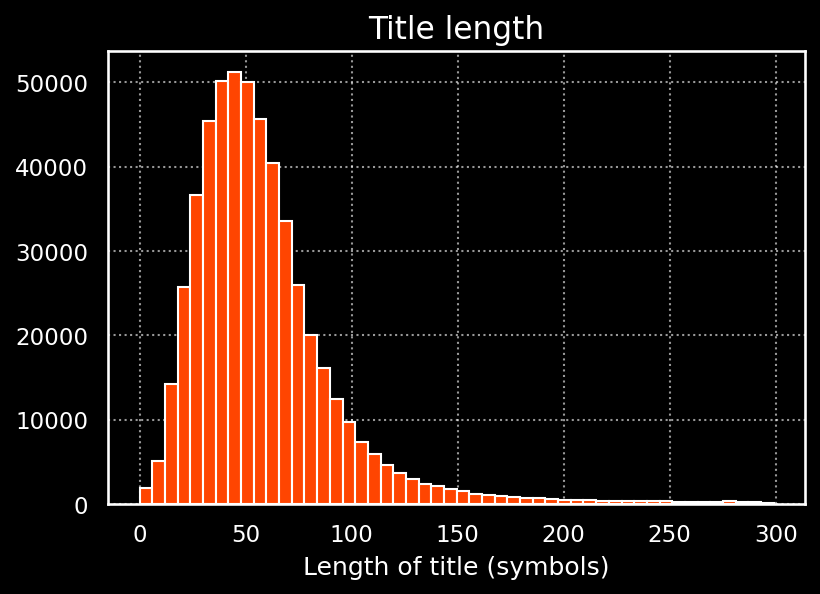

In [16]:
title_length = title_cleaned.str.len()

plt.title('Title length', size = 15, color = 'white')
sns.distplot(title_length, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of title (symbols)')
plt.show()

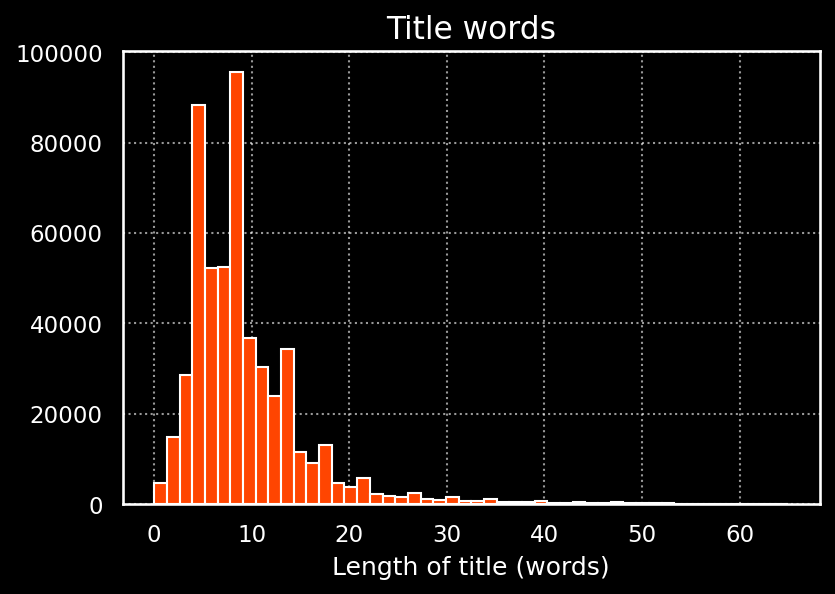

In [17]:
title_words = title_cleaned.str.split().map(lambda x: len(x))

plt.title('Title words', size = 15, color = 'white')
sns.distplot(title_words, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of title (words)')
plt.show()

Some of the titles are really long! (almost 60 words and 300 characters).

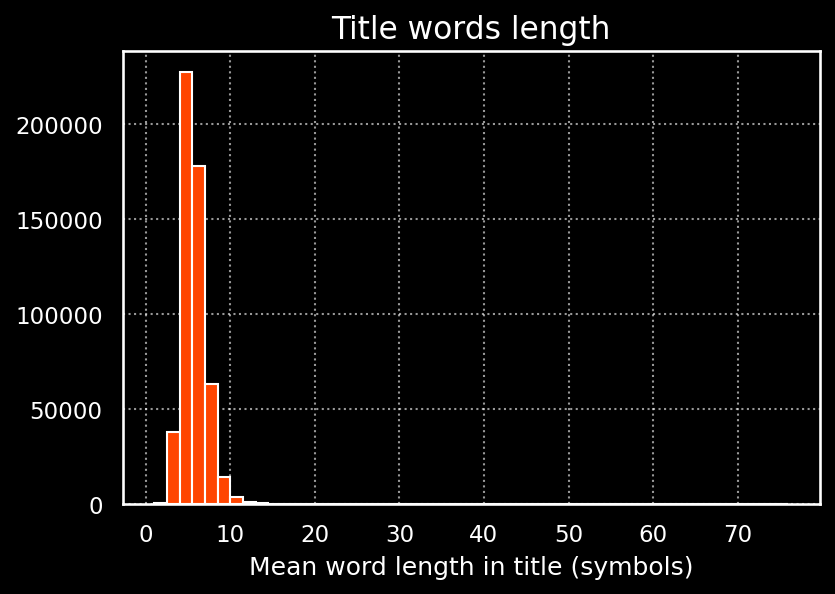

In [18]:
title_word_len = title_cleaned.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

plt.title('Title words length', size = 15, color = 'white')
sns.distplot(title_word_len, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Mean word length in title (symbols)')
plt.show()

In [19]:
words = title_cleaned.str.split().values.tolist()
title_corpus = [word for i in words for word in i]

title_counter = Counter(title_corpus)
title_most = title_counter.most_common()

stop = set(stopwords.words('english'))

title_top_words, title_top_words_count = [], []
for word, count in title_most[:100]:
    if word not in stop:
        title_top_words.append(word)
        title_top_words_count.append(count)

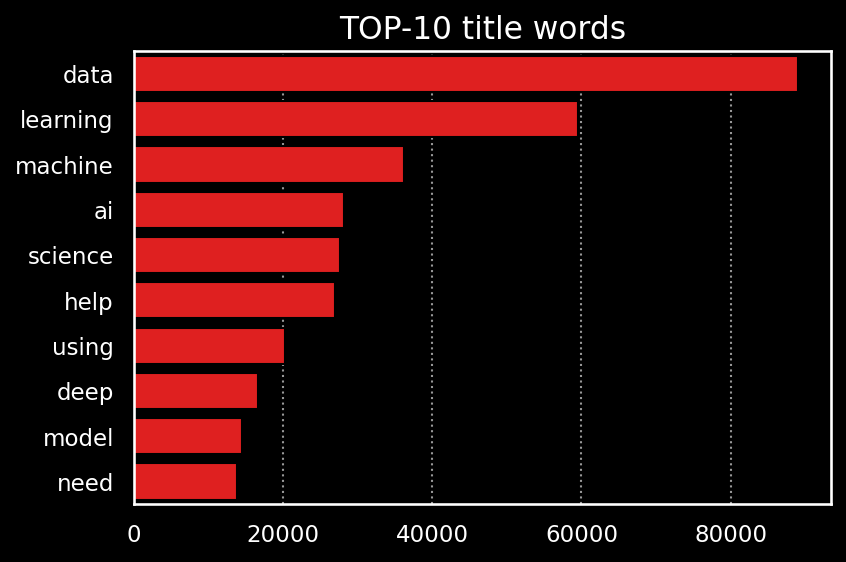

In [20]:
plt.title('TOP-10 title words', color = 'white', size = 15)
sns.barplot(y = title_top_words[:10], x = title_top_words_count[:10], 
            edgecolor = 'black', color = 'red')
plt.show()

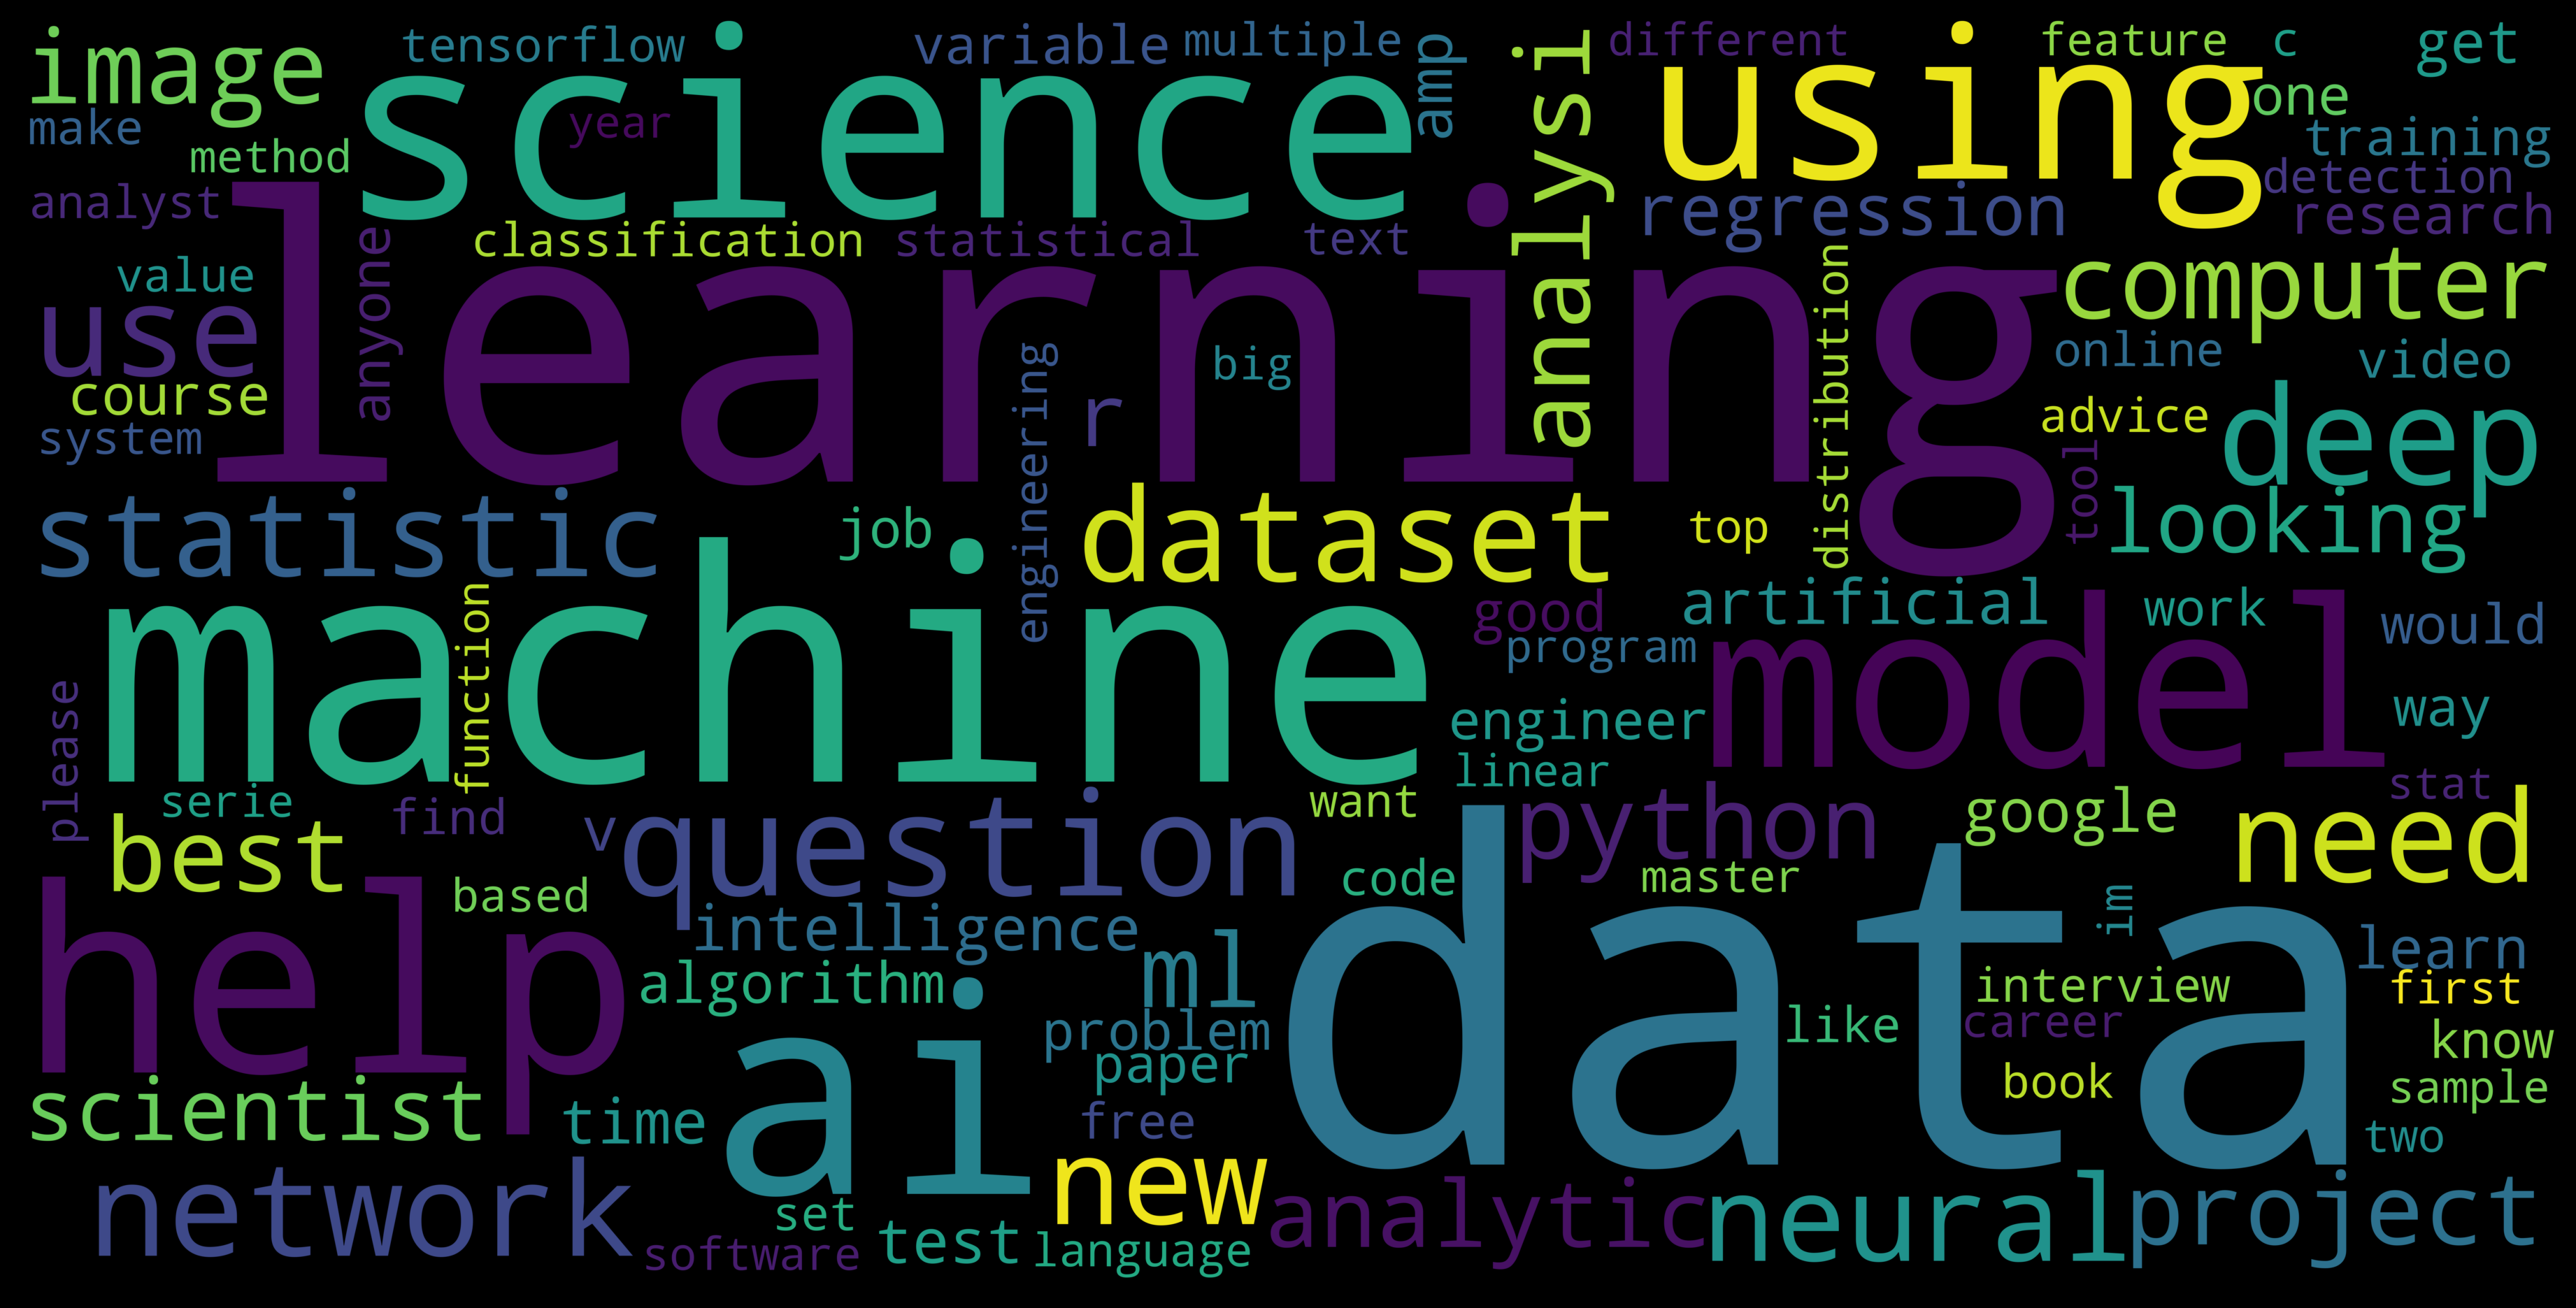

In [21]:
title_word_string = ' '.join(title_corpus)
show_wordcloud(title_word_string, stop)

As expected, the titles are dominated by the words "data", "machine", "learning", "ai", "science", "deep", "model" ...

It is also interesting to look at the bigrams and trigrams of titles.

In [22]:
# Data for bigrams
top_title_bigrams = get_top_ngram(title_cleaned, 2)[:10]
title_x, title_y = map(list, zip(*top_title_bigrams))

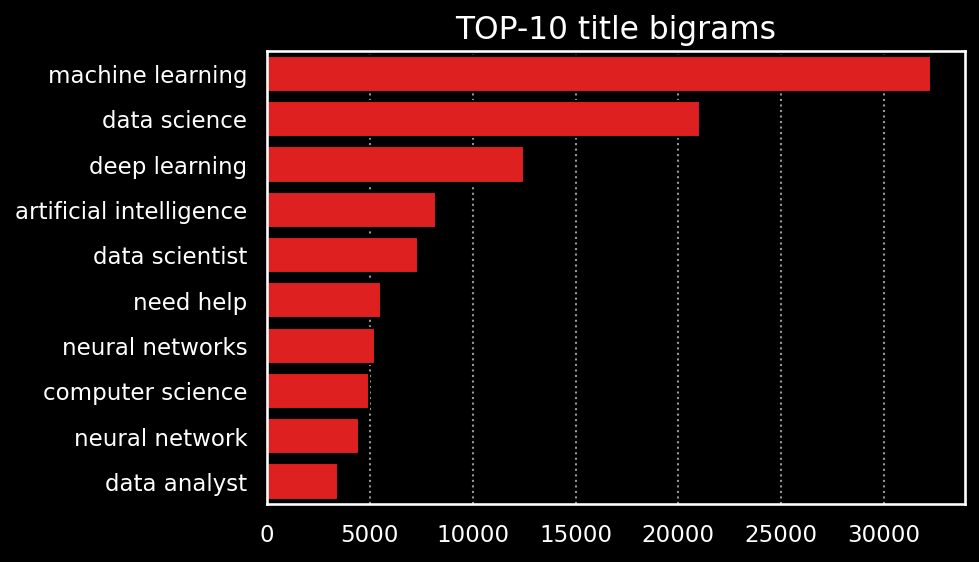

In [23]:
plt.title('TOP-10 title bigrams', color = 'white', size = 15)
sns.barplot(x = title_y, y = title_x, edgecolor = 'black', color = 'red')
plt.show()

In [24]:
# Data for bigrams
top_title_trigrams = get_top_ngram(title_cleaned, 3)[:10]
title_x, title_y = map(list, zip(*top_title_trigrams))

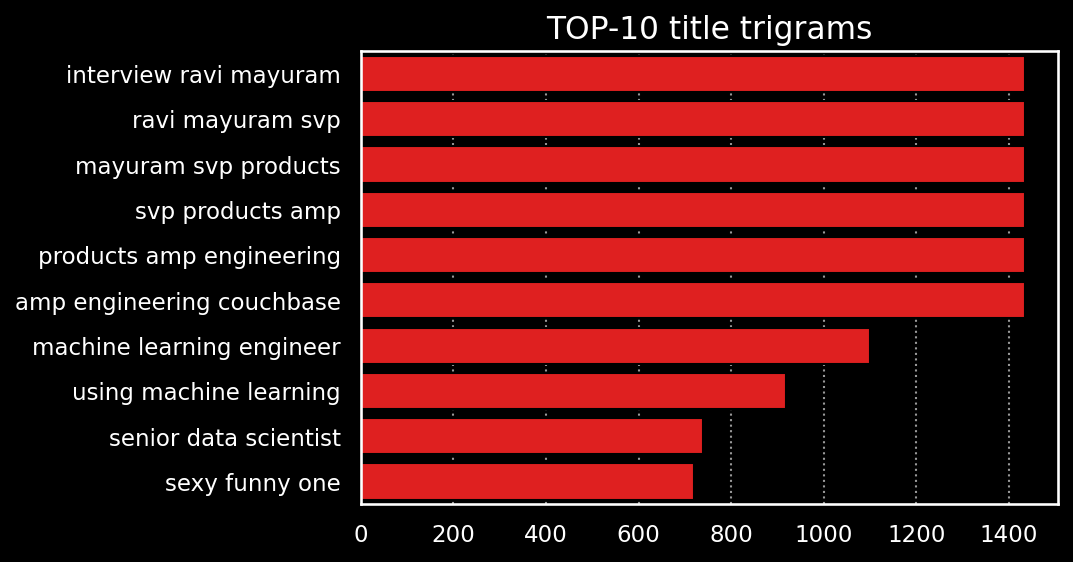

In [25]:
plt.title('TOP-10 title trigrams', color = 'white', size = 15)
sns.barplot(x = title_y, y = title_x, edgecolor = 'black', color = 'red')
plt.show()

### Let's look at the posts data.

In [26]:
post_cleaned = all_data['post'].dropna().progress_apply(lambda x: text_cleaner(x))

  0%|          | 0/262567 [00:00<?, ?it/s]

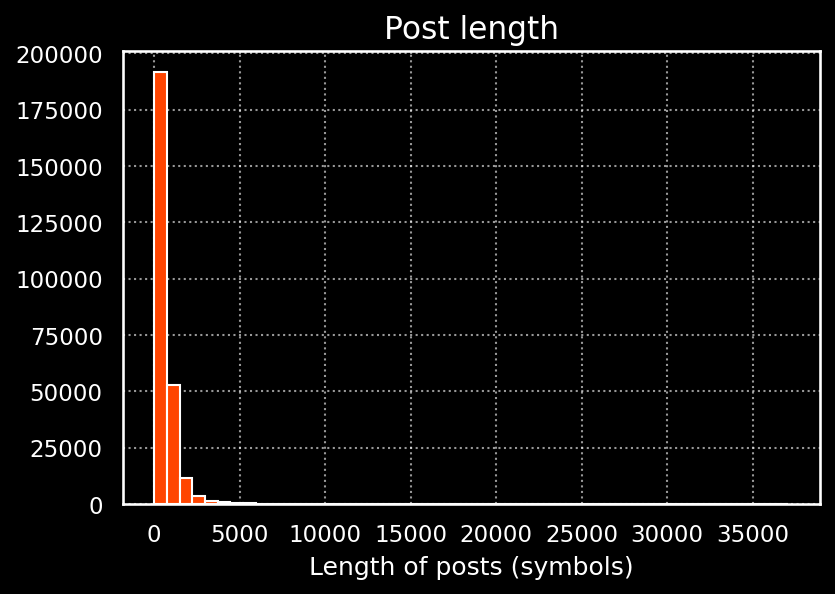

In [27]:
post_length = post_cleaned.str.len()

plt.title('Post length', size = 15, color = 'white')
sns.distplot(post_length, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of posts (symbols)')
plt.show()

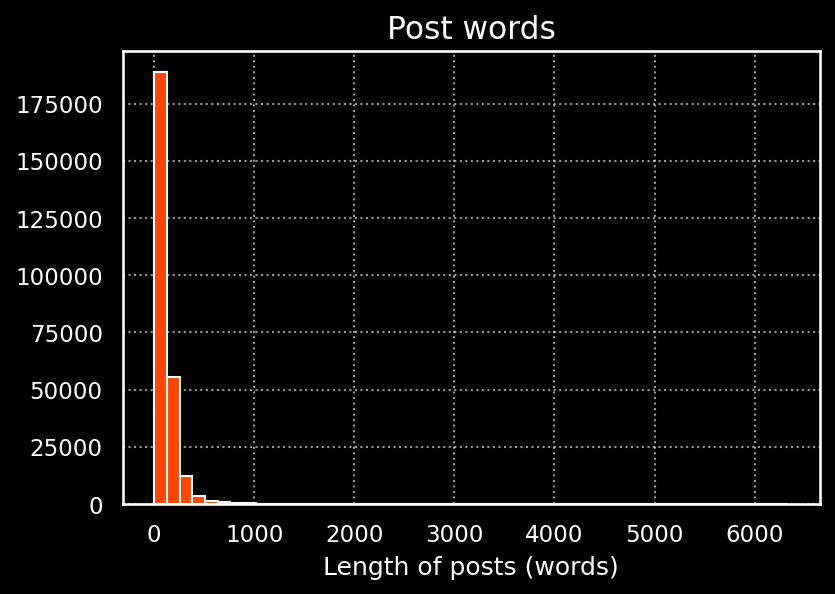

In [28]:
post_words = post_cleaned.str.split().map(lambda x: len(x))

plt.title('Post words', size = 15, color = 'white')
sns.distplot(post_words, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of posts (words)')
plt.show()

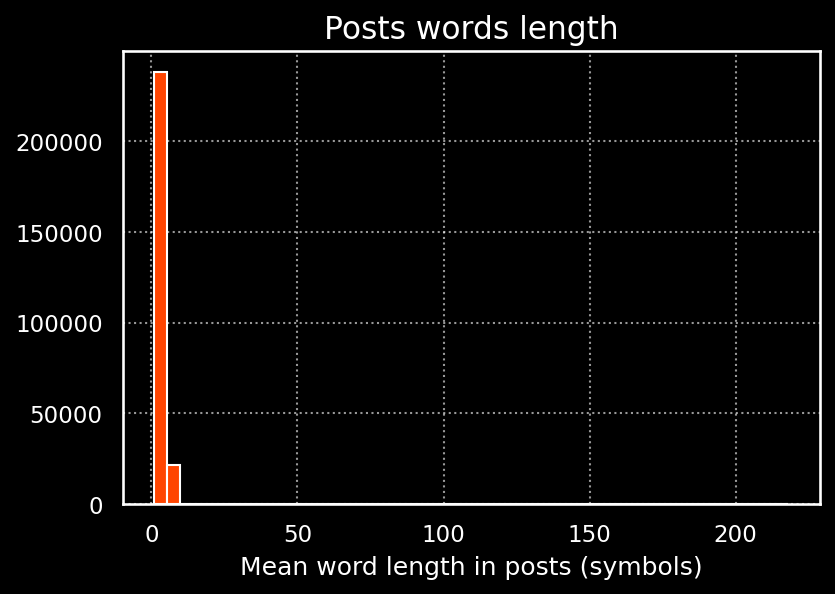

In [29]:
post_word_len = post_cleaned.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

plt.title('Posts words length', size = 15, color = 'white')
sns.distplot(post_word_len, kde = False, color = '#ff4501', 
             hist_kws = dict(alpha = 1))
plt.xlabel('Mean word length in posts (symbols)')
plt.show()

In [30]:
words = post_cleaned.str.split().values.tolist()
post_corpus = [word for i in words for word in i]

post_counter = Counter(post_corpus)
post_most = post_counter.most_common()

stop = set(stopwords.words('english'))

post_top_words, post_top_words_count = [], []
for word, count in post_most[:100]:
    if word not in stop:
        post_top_words.append(word)
        post_top_words_count.append(count)

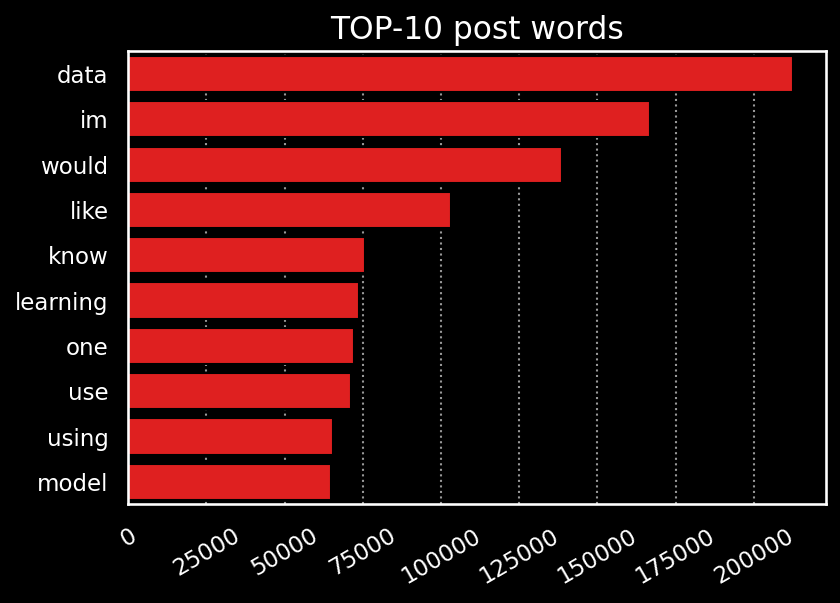

In [31]:
plt.title('TOP-10 post words', color = 'white', size = 15)
sns.barplot(y = post_top_words[:10], x = post_top_words_count[:10], 
            edgecolor = 'black', color = 'red')
plt.xticks(rotation = 30)
plt.show()

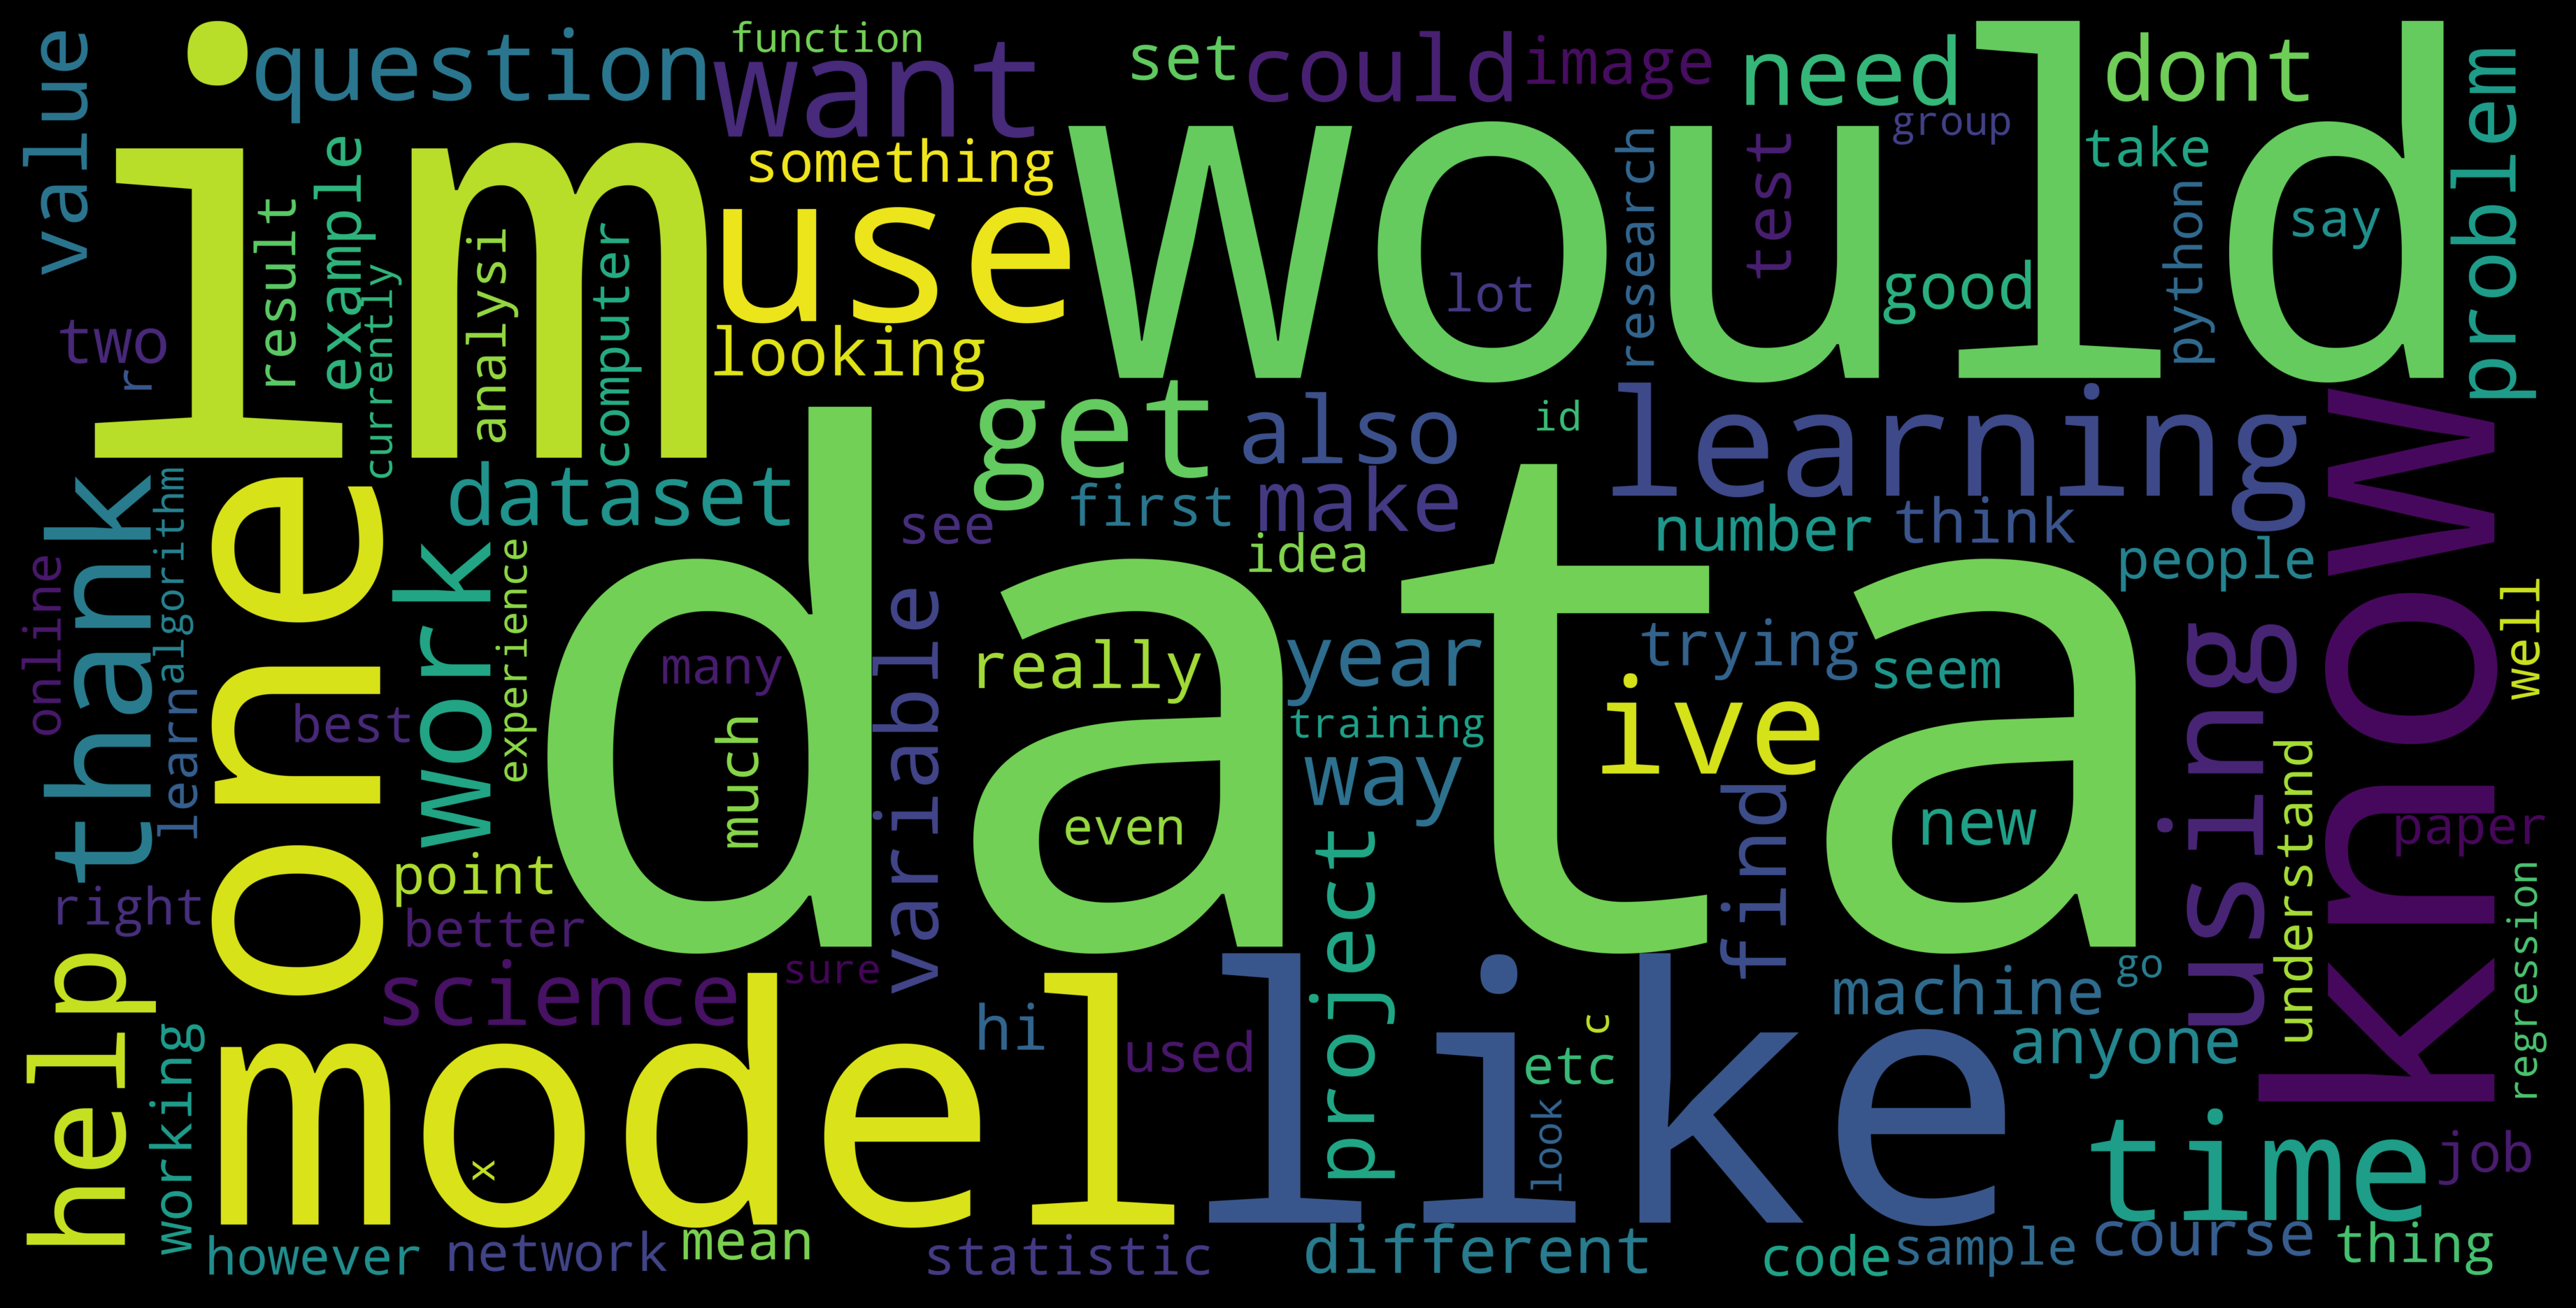

In [32]:
post_word_string = ' '.join(post_corpus)
show_wordcloud(post_word_string, stop)

**The deserved king of all posts is the word "data".**

In [33]:
# Data for bigrams
top_post_bigrams = get_top_ngram(post_cleaned, 2)[:10]
title_x, title_y = map(list, zip(*top_post_bigrams))

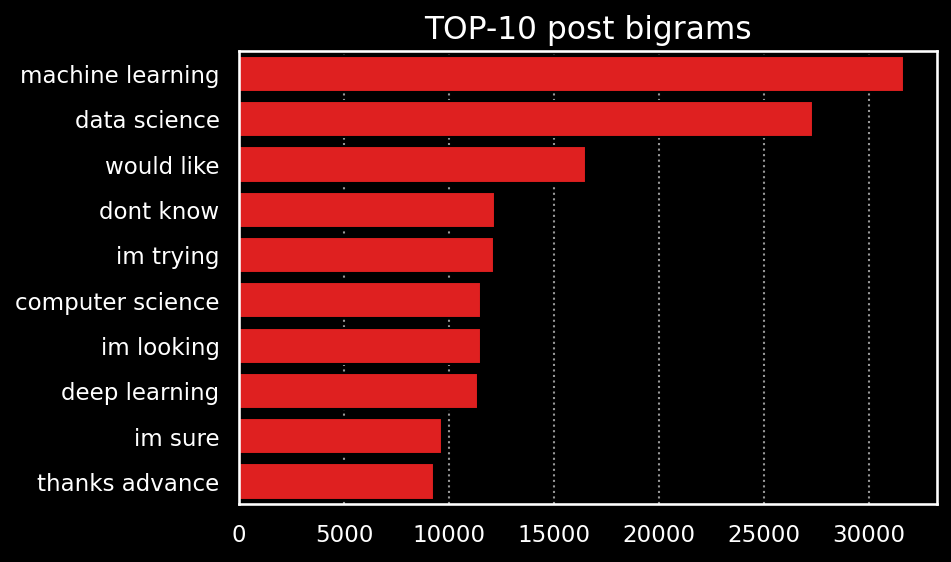

In [34]:
plt.title('TOP-10 post bigrams', color = 'white', size = 15)
sns.barplot(x = title_y, y = title_x, edgecolor = 'black', color = 'red')
plt.show()

In [35]:
# Data for bigrams
top_post_trigrams = get_top_ngram(post_cleaned, 3)[:10]
title_x, title_y = map(list, zip(*top_post_trigrams))

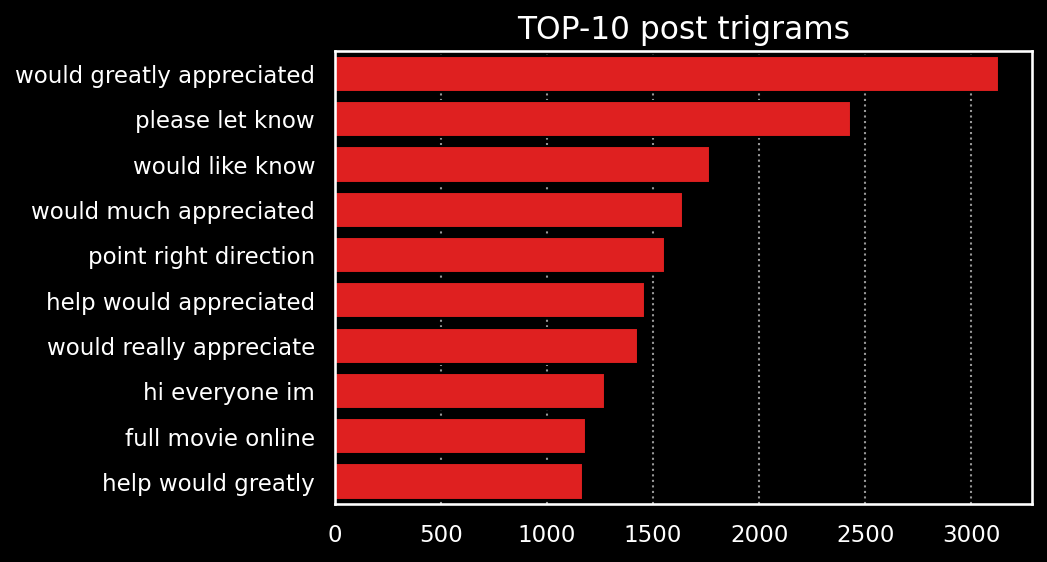

In [36]:
plt.title('TOP-10 post trigrams', color = 'white', size = 15)
sns.barplot(x = title_y, y = title_x, edgecolor = 'black', color = 'red')
plt.show()

# RAPIDS and post title

Now let's formulate, and immediately solve our first problem. Let's say we want to analyze the titles of all our posts and find similar ones. The task seems to be quite simple: you just need to turn titles into a vector representation and find the distance using KNN (K-Nearest Neighbors). The difficulty arises with the size of the data. Half a million titles (some of which are really big) are a lot for KNN. Therefore, we use RAPIDS - open-source software libraries that give you the freedom to execute end-to-end data science and analytics pipelines entirely on GPUs.

Great, let's try. First, we will set some parameters for using RAPIDS GPU.

In [37]:
LIMIT = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('Restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('so RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

1 Physical GPUs, 1 Logical GPUs
Restrict TensorFlow to max 1GB GPU RAM
so RAPIDS can use 15GB GPU RAM


Then we create a TfidfVectorizer object and transform the first 50 000 titles into a vector representation (no longer allowed by the notebook limitation).

In [38]:
vectorizer = TfidfVectorizer(stop_words = 'english', binary = True)
title_embeddings = vectorizer.fit_transform(cudf.Series(all_data.loc[:49999, 'title'])).toarray()
print('Title embeddings shape:', title_embeddings.shape)

Title embeddings shape: (50000, 22696)


Now it's time to use the K nearest neighbors method on our embeddings. For each title, we will find 10 nearest neighbors.

In [39]:
KNN = 10
model = NearestNeighbors(n_neighbors = KNN)
model.fit(title_embeddings)
distances, indices = model.kneighbors(title_embeddings)

In [40]:
def knn_viz(rows, k_neighbors = 15):
    for i in rows:
        plt.figure(figsize = (20, 3))
        plt.plot(np.arange(k_neighbors), 
                 cupy.asnumpy(distances[i, :k_neighbors]), 'o--', 
                 color = 'red', linewidth = 3, markersize = 12)
        plt.title('Text Distance From Row %i to Other Rows'%i, 
                  size = 16, color = 'white')
        plt.ylabel('Distance to Row %i'%i, size = 14)
        plt.xlabel('Index Sorted by Distance to Row %i'%i, size = 14)
        plt.show()

        print(all_data.loc[cupy.asnumpy(indices[i, :k_neighbors]), 'title'])

Now let's visualize the nearest neighbors for the first five titles. The graphs show the distance between neighbors (the shorter the distance, the more similar the titles are). Below each graph are the titles themselves.

We can see that some of the titles are quite unique. And some, such as 0 and 2, have quite similar analogs, or even exact copies.

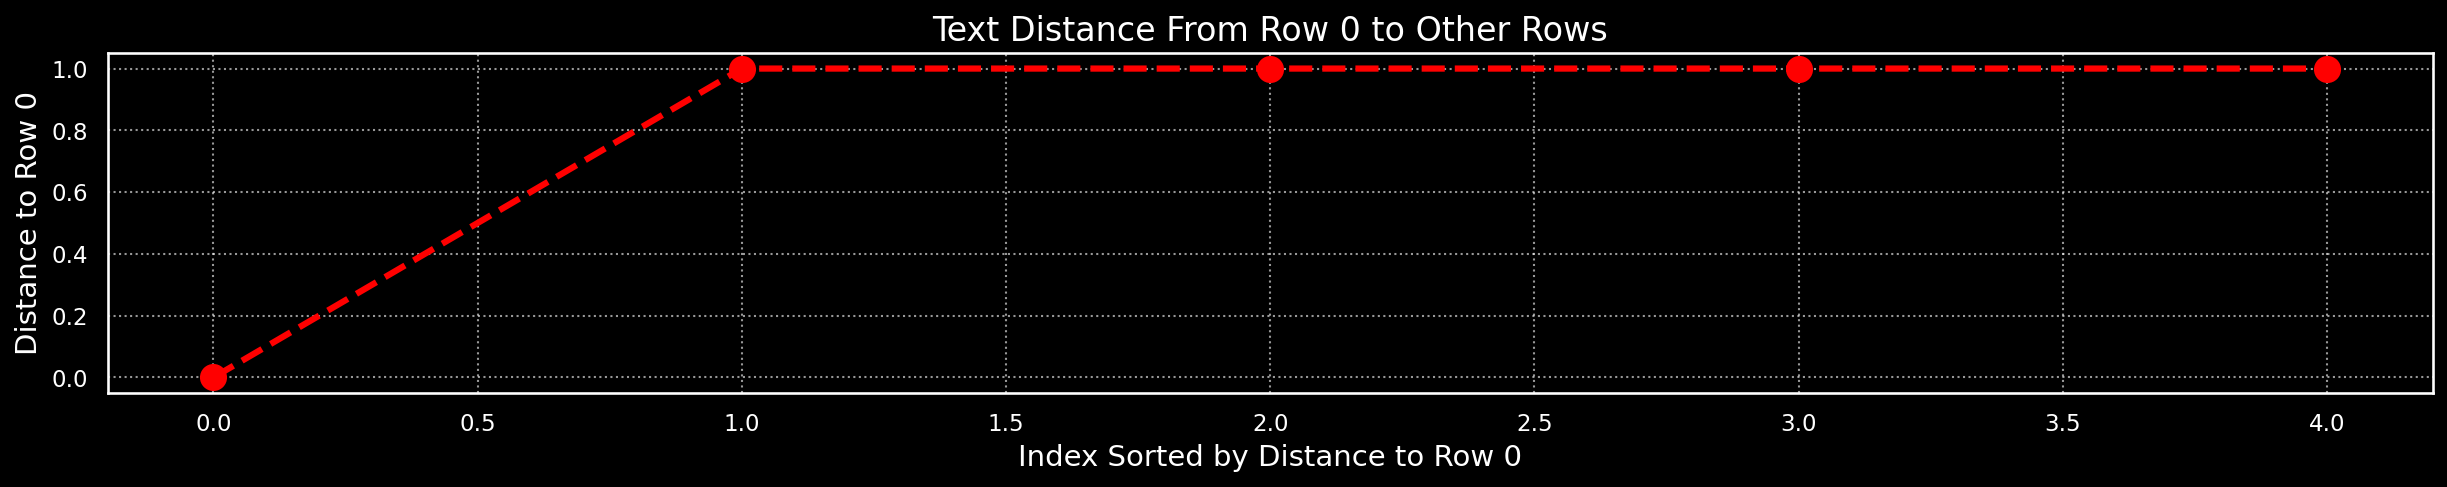

0        YouTube's traffic data for music questioned
21913                                What to do next
31751                             What should I do ?
24579                               How to get both?
30599                                              😂
Name: title, dtype: object


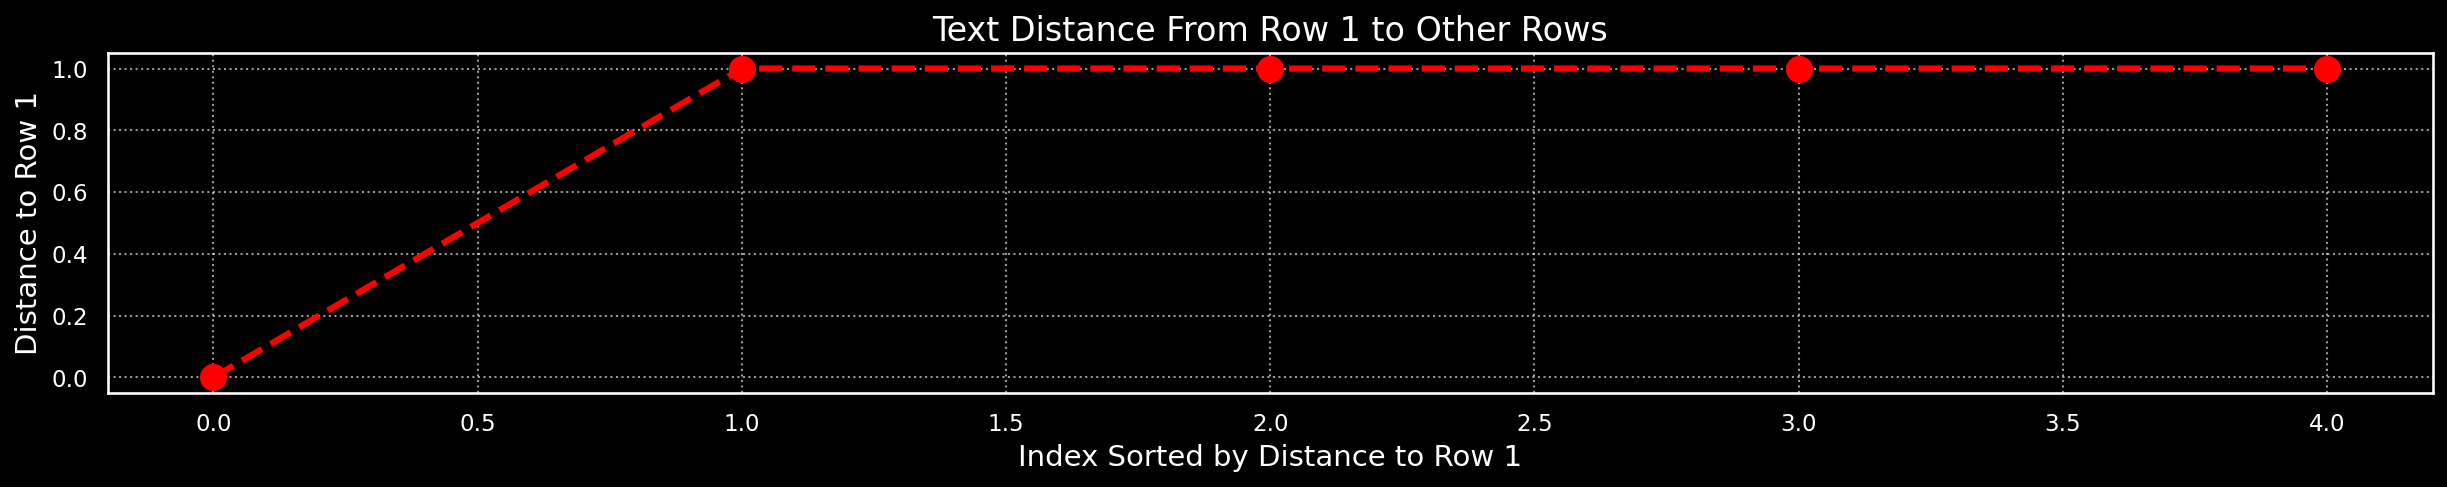

1        November Sees Number of U.S. Videos Viewed Onl...
21913                                      What to do next
31751                                   What should I do ?
24579                                     How to get both?
30599                                                    😂
Name: title, dtype: object


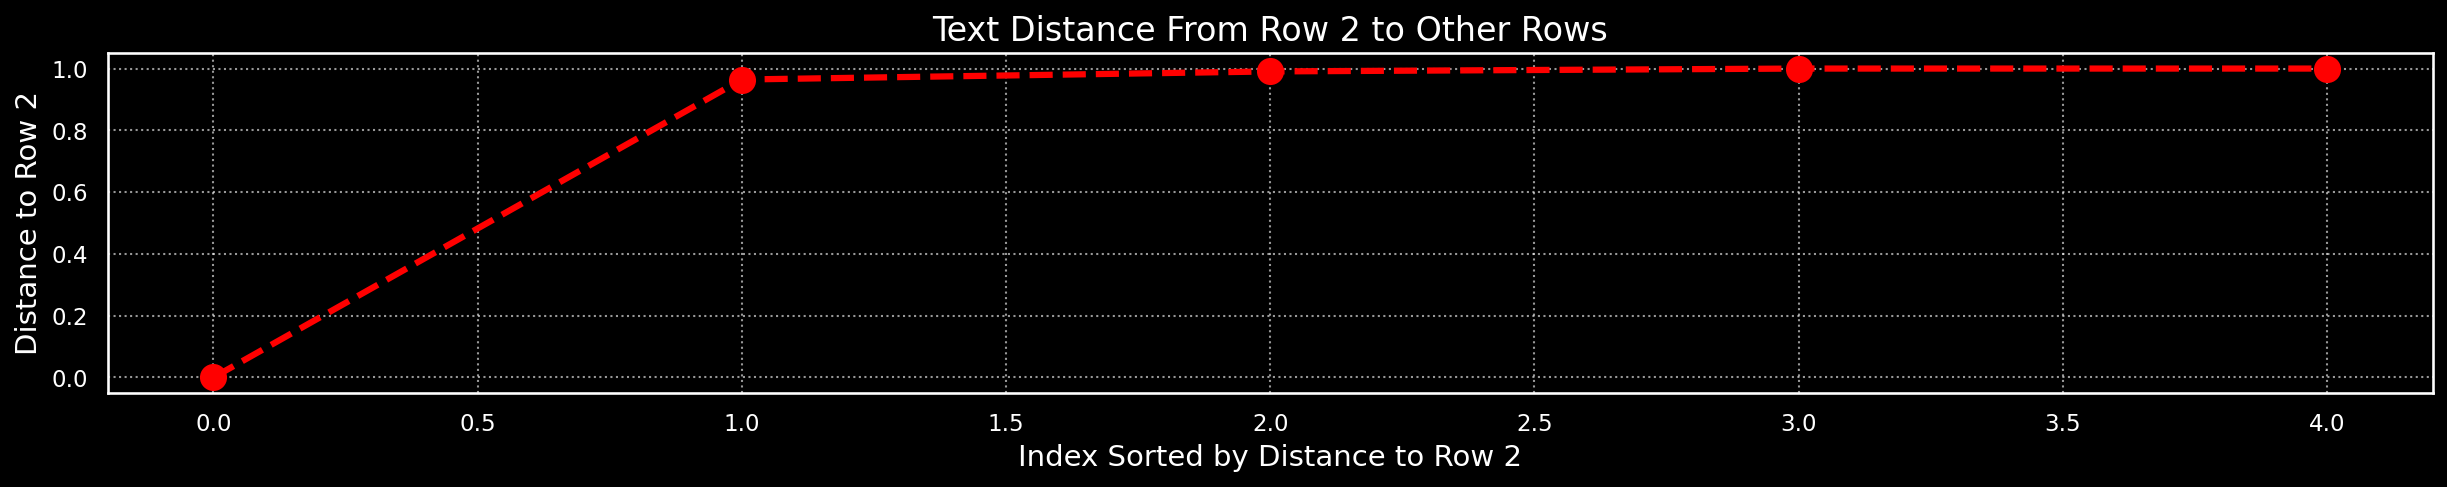

2        So what do you guys all do related to analytic...
16338                       Related Jobs to Data Analytics
9037     Are these guys for real? Every analytics tool ...
25740                                         What’s next?
21913                                      What to do next
Name: title, dtype: object


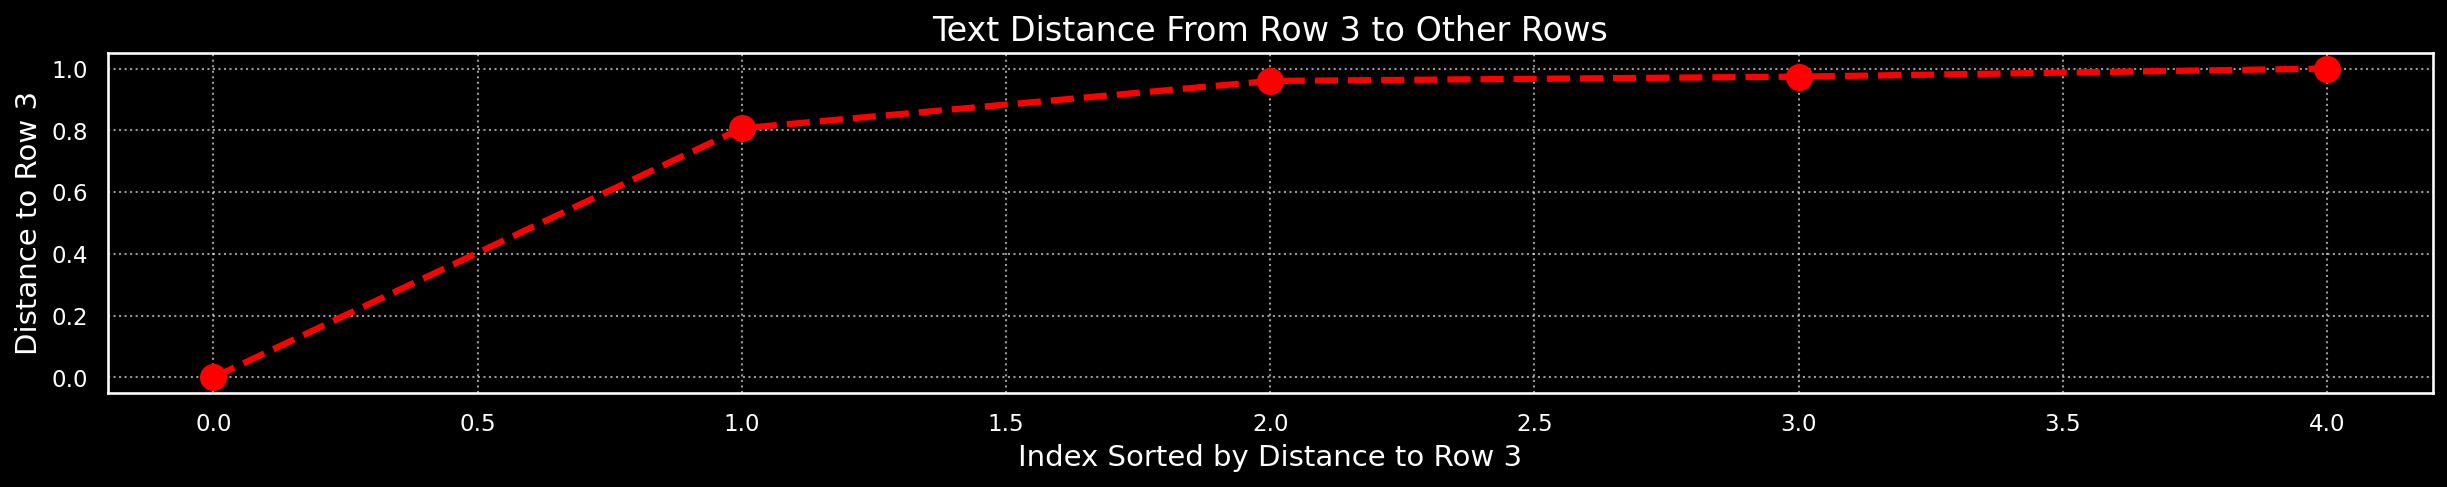

3        10 Web Analytics Tools For Tracking Your Visitors
4285                           10 Best Web Analytics Tools
3538     10 Amazing Web Analytics Tools: How to Make Th...
1548                   The 10 Smartest Web Analytics Tools
21913                                      What to do next
Name: title, dtype: object


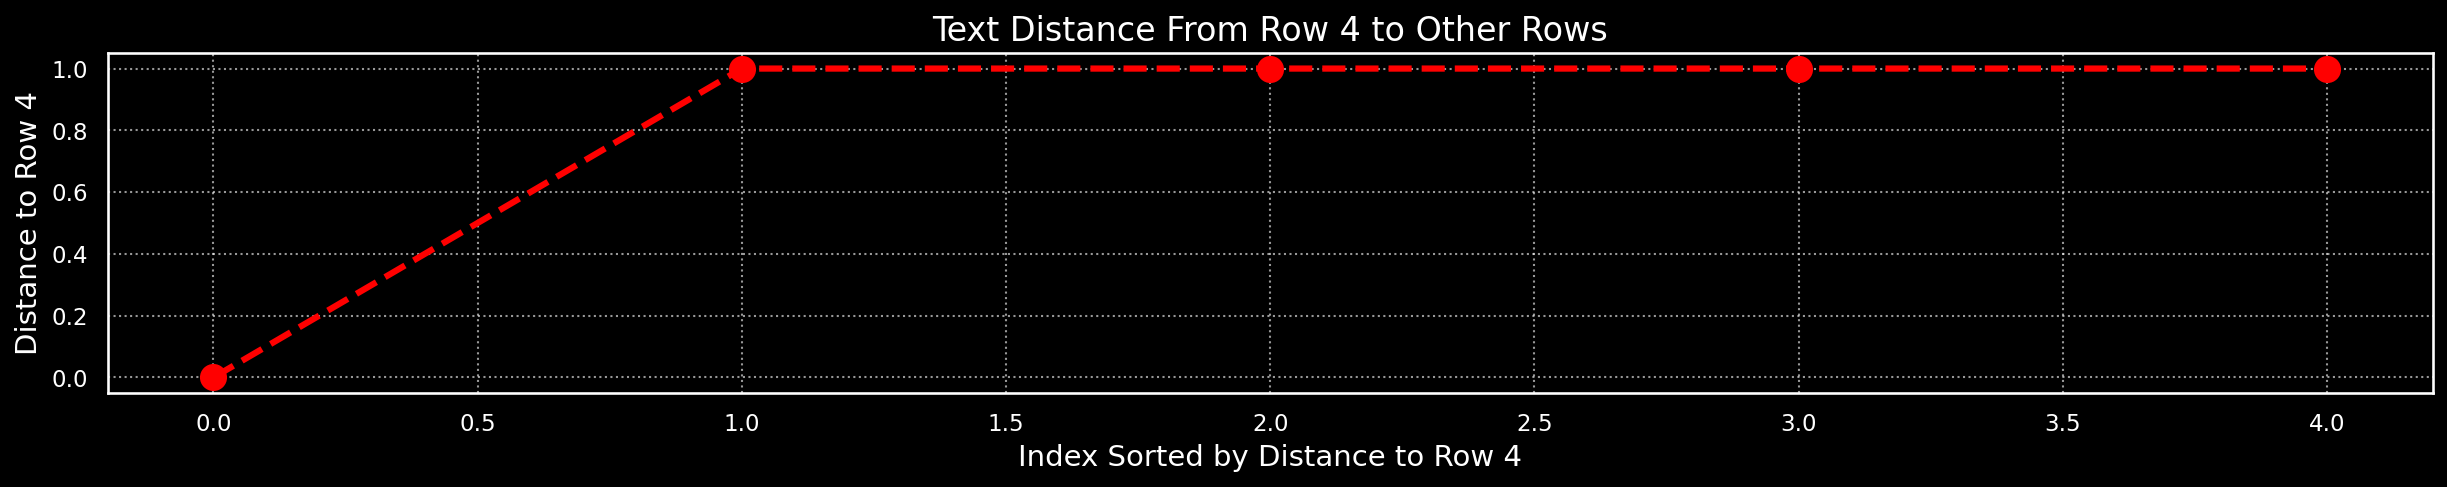

4        Improving Your Sense of Site
25740                    What’s next?
31751              What should I do ?
30599                               😂
21913                 What to do next
Name: title, dtype: object


In [41]:
knn_viz(range(5), 5)

<h1 style='color:white; background:black; border:0'><center>WORK IN PROGRESS...</center></h1>

# If you are interested, see [this dataset (Reddit Data Science Posts)](https://www.kaggle.com/maksymshkliarevskyi/reddit-data-science-posts).